## LSTM (long short-term memory) based Recurrent NeuralNet for share price forecasting
###### Abdulla Al Blooshi
----------------
- As an overview, the idea behind this model architecture is to assign weights to selected features; in this case the **open** and the **highest** price the stock reached for a given day were selected. These learned weights represents the model's view on the importance of said features from recent and previous time blocks and how they affect the price in the coming day(s).
- This model will be trained on ADNOC's stock price history and the weights it learns will be saved and used via a transfer learning approach to be tested on and predict Borouge's future stock price.
- This was done due to the lack of training data for Borouge's stock price as it (relatively) recently IPO'd
<br>
<br>
> *This is by no means financial advice as I am not a financial expert, and all the data used here is publicly available.*

In [3]:
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
import tensorflow.keras as keras 
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LSTM
)
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### Splitting and normalizing the data:
   - It is easier for the model to work with numbers that are closer together; namely in the range of (0,1) for our case
   - The `MinMaxScaler()` transformation is given by:
      
        X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))<br>
        X_scaled = X_std * (max - min) + min <br>
        
        *where min, max = feature_range.*
        > taken straight from the docs

In [4]:
unsplit_dat = pd.read_csv('./data/ADNOCDIST_Historical_Data.csv', index_col='Date')
valid_dat = pd.read_csv('./data/ADNOC_Valid.csv', index_col='Date')


total_set = unsplit_dat[['Open']].values

# *Shuffle set to false for smaller dataset to avoid sampling bias, default behavior is shuffle first then split
training_set, test_set = train_test_split(total_set, test_size=0.02, random_state=44, shuffle=False)

valid_set = valid_dat[['Open']].values

normalizer = MinMaxScaler(feature_range=(0,1))

scaled_train_set = normalizer.fit_transform(training_set)
scaled_valid_set = normalizer.fit_transform(valid_set)
# scaled_test_set = normalizer.fit_transform(test_set)
# scaled_total_set = normalizer.fit_transform(total_set)

print(f"Training set\n{scaled_train_set[:10]}\nValidation set\n{scaled_valid_set[:10]}\nTest set\n{test_set[:10]}")
training_set.shape

Training set
[[0.70333333]
 [0.70333333]
 [0.69333333]
 [0.69      ]
 [0.68666667]
 [0.69333333]
 [0.69      ]
 [0.68666667]
 [0.70666667]
 [0.70333333]]
Validation set
[[0.8       ]
 [0.8       ]
 [0.9       ]
 [0.86666667]
 [0.9       ]
 [0.73333333]
 [0.7       ]
 [0.93333333]
 [0.83333333]
 [0.8       ]]
Test set
[[2.64]
 [2.61]
 [2.62]
 [2.62]
 [2.65]
 [2.62]
 [2.62]
 [2.6 ]
 [2.6 ]
 [2.62]]


(1023, 1)

#### LSTMs distinguishing features and other important notes:
- As per the [paper](http://www.bioinf.jku.at/publications/older/2604.pdf) first proposing this architecture by Hochreiter et al. Constant error carousels (CEC) are the central features of LSTMs. Controlling (deciding) the backward propagation of errors through the network.
    - These CEC's are then extended to form what is referred to as a memory cell; the extension adds multiplicative input and output gates. These gates control the contents with in a cell from being propagated and control the cell from activating other units respectively.
- RNNs are able to use recently seen previous information and cannot do so with information with larger time lags between them, this is where the LSTM architecture comes into play.
- This is another one of the distinguishing features of using the LSTM architecture, its ability to 'remember' or erase parts of previously seen data in a window (or timestep).
- By creating a window our training data will be turned into an array of arrays divided into chunks of N, where N would be the size of our timestep/window.
    - for example having N be 60 would allow our model to use the previous sixty days of data to make the prediction for the 61st.


In [5]:
#TODO: y_train should predict close prices?
#TODO: Consider using sklearn's standardScaler()
X_train=[]
y_train=[]
X_valid=[]
y_valid=[]

for i in range(60,scaled_train_set.shape[0]):
    X_train.append(scaled_train_set[i-60:i,0])
    y_train.append(scaled_train_set[i,0])

for j in range(60,scaled_valid_set.shape[0]):
    X_valid.append(scaled_valid_set[j-60:j,0])
    y_valid.append(scaled_valid_set[j,0])

# Keras accepts numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

X_valid, y_valid = np.array(X_valid), np.array(y_valid) 
print(X_train.shape, y_train.shape)

(963, 60) (963,)


#### Implementation Notes:
- The model base architecture will be sequential which ["_groups a linear stack of layers into a tf.keras.Model_"](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
- Ideally I would've liked to add more dropout layers but I do not have that luxury as data is limited. The dropout layers aids in reducing the amount of overfitting.

___However, before we can do that the data must be transformed further into a 3D array with X_train learning examples. In our case it will be of dimension (984,60,1), the 984 comes from the number of samples we have, the 60 is because we grouped our samples into groups of 60, and the 1 is because we want the model to access one feature at each timestep___ 


In [6]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_valid = np.reshape(X_valid,(X_valid.shape[0],X_valid.shape[1],1))

In [7]:
X_train.shape

(963, 60, 1)

In [8]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=32, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(units=32, return_sequences=True))
lstm_model.add(Dropout(0.05))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dropout(0.05))
lstm_model.add(Dense(units=1))

lstm_model.summary()
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
dropout (Dropout)            (None, 60, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 32)            8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

#### Training the model on the data:

In [9]:
lstm_model.fit(X_train, y_train, epochs=100,batch_size=32,validation_data=(X_valid,y_valid))

Epoch 1/100
31/31 [==============================] - 8s 78ms/step - loss: 0.0380 - val_loss: 0.0264
Epoch 2/100
31/31 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 0.0263
Epoch 3/100
31/31 [==============================] - 1s 47ms/step - loss: 0.0028 - val_loss: 0.0266
Epoch 4/100
31/31 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0277
Epoch 5/100
31/31 [==============================] - 1s 45ms/step - loss: 0.0021 - val_loss: 0.0278
Epoch 6/100
31/31 [==============================] - 1s 45ms/step - loss: 0.0021 - val_loss: 0.0274
Epoch 7/100
31/31 [==============================] - 1s 46ms/step - loss: 0.0022 - val_loss: 0.0271
Epoch 8/100
31/31 [==============================] - 1s 45ms/step - loss: 0.0022 - val_loss: 0.0286
Epoch 9/100
31/31 [==============================] - 1s 45ms/step - loss: 0.0020 - val_loss: 0.0283
Epoch 10/100
31/31 [==============================] - 1s 45ms/step - loss: 0.0021 - val_loss: 0.0265

#### Testing the model on unseen data

- After training the validation loss is reasonably larger than loss on the training set, hinting towards the possibility of underfitting 
- Possible solutions are:
    - Parameter increase
    - Additional layers of
    - Increased training set size

In [10]:
%who

Dense	 Dropout	 LSTM	 MinMaxScaler	 SGD	 Sequential	 X_train	 X_valid	 h5py	 
i	 j	 keras	 lstm_model	 normalizer	 np	 os	 pd	 plt	 
save_model	 scaled_train_set	 scaled_valid_set	 sys	 test_set	 total_set	 train_test_split	 training_set	 unsplit_dat	 
valid_dat	 valid_set	 y_train	 y_valid	 


In [11]:
# len(scaled_total_set)-len(scaled_test_set)-60 = 963 = X_train.shape[0], the remaining being test
tests=total_set[len(total_set)-len(test_set)-60:]
tests = tests.reshape(-1,1)
# tests = tests.reshape(-1,1)
tests = normalizer.transform(tests)

X_test=[]
# Creating the same window and dimensions as before
for e in range(60,tests.shape[0]):
    X_test.append(tests[e-60:e,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

model_prediction = lstm_model.predict(X_test)
model_prediction = normalizer.inverse_transform(model_prediction)
model_prediction

array([[3.532275 ],
       [3.5325406],
       [3.532654 ],
       [3.532607 ],
       [3.5324569],
       [3.5321834],
       [3.5318081],
       [3.5313525],
       [3.5309105],
       [3.5304813],
       [3.5300736],
       [3.52966  ],
       [3.5292363],
       [3.5288703],
       [3.528461 ],
       [3.52798  ],
       [3.5274084],
       [3.526724 ],
       [3.5259914],
       [3.5254593],
       [3.525298 ]], dtype=float32)

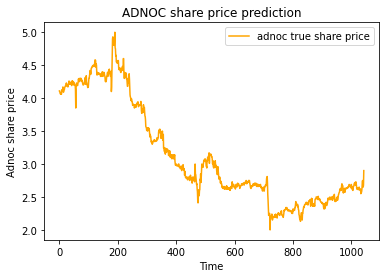

In [21]:
plt.plot(total_set, color='orange',label='adnoc true share price')
# !in dire need of revision, this model needs saving xD
# plt.plot(model_prediction, color='black',label='model prediction')
plt.title('ADNOC share price prediction')
plt.xlabel('Time')
plt.ylabel('Adnoc share price')
plt.legend()
plt.show()


In [13]:
lstm_model.save('transferable.h5')

<ul style="color:orange">
<li>TODO: ExponMovingAvg for comparison</li>
<li>TODO: Data visualization</li>
<li>TODO: Save model and use transfer learning to apply to Borouge stock</li>
</ul>